# Random basics - universal approximation theorem - regression & classification

Neural nets are highly flexible functions which can be used to approximate functions/relationships latent in a given data set. The explanation of this flexibility relates to the so-called _universal approximation theorem_. This was mentioned in one of fastai's lectures given by Jeremy Howard referring to the book by Michael Nielsen linked below. Do check it out, it's amazing.

For reasons I wanted to implement something similar as in the book to play with various aspects beyond the concrete weights, more related to the used activation functions and so on. The idea is to set up some wild function which takes `x` and `y` and spits out `z` (so we can have a fancy 3d plots 😬) and fiddle with the network and optimization properties seeing all the ways it can fail and those where it does not. 

Because fitting continuous values, regression, really is only half of the supervised pie I also added something to predict discrete values, classification, playing around with multi-class classification. There I added a visual comparison of two ways the activations of the final layer can be interpreted. One method returns a score for each class whether it is present or not (sigmoid) and the other how a class compares to others (softmax).

**Things in this notebook**
- ipywidgets-awesomeness for exploration
- single neuron fit → regression
- multi neuron multi layer fit → regression / classification

**Order of things**
1. single neuron → regression
2. multi-multi → regression
3. multi-multi → classification with sigmoid/softmax comparison

**References**

- Michael Nielsen, A visual proof that neural nets can compute any function, [chapter 4](http://neuralnetworksanddeeplearning.com/chap4.html), 2019 

## Fitting a 2d surface with a single neuron

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
import ipywidgets as widgets
from typing import Union, List
import matplotlib.colors as colors

Generating a simple plot using one of the standard activation functions

In [408]:
n = int(1e3)
dim = 2
X = torch.zeros((n,dim))
X[:,0].uniform_(-1, 1)
X[:,1].uniform_(-1, 1)
w = torch.ones(2)
y = torch.tanh(X@w)

Plotting `y` (coloured circles) and "`y_pred`" (black dots)

In [409]:
def plotter_wrapper(X:torch.Tensor, y:torch.Tensor, y_pred:torch.Tensor=None, figsize=(10,10)):

    def dynamic3d_scatter(elev=3, azim=-55):
        fig = plt.figure(figsize=figsize)
        ax = fig.gca(projection="3d")
        ax.scatter(X[:,0], X[:,1], zs=y , c=y, marker="o", alpha=.5)
        if y_pred is not None:
            ax.scatter(X[:,0], X[:,1], zs=y_pred , c="k", marker=".", alpha=.5)
        ax.view_init(elev=elev, azim=azim)  # elev=20., azim=-55
        plt.show()
        
    return dynamic3d_scatter

dynamic3d_scatter = plotter_wrapper(X, y, y_pred=y)
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

Defining the single neuron model

In [413]:
class Model(torch.nn.Module):
    
    def __init__(self, activation_fun:Union[str,callable]="relu", dim_in:int=2, dim_out:int=1):
        super().__init__()
        self.lin = torch.nn.Linear(dim_in, dim_out)
        self.set_activation(activation_fun)
        
    def set_activation(self, fun_name):
        if fun_name is None:
            self.activation = lambda x: x
        else:
            self.activation = getattr(torch.nn.functional, fun_name) if isinstance(fun_name, str) else fun_name
        
    def forward(self, x):
        return self.activation(self.lin(x)).squeeze(1)

device = torch.device("cpu")
m = Model(activation_fun=None, dim_in=dim, dim_out=1)
m.to(device)

Model(
  (lin): Linear(in_features=2, out_features=1, bias=True)
)

Defining loss function and optimizer

In [414]:
loss = torch.nn.functional.mse_loss
opt = torch.optim.Adam(m.parameters(), lr=.01)
print(loss)

<function mse_loss at 0x000001BA2F13DC18>


Iterating away in the search of the global minimum

In [415]:
n_iter = 100

In [417]:
m.train()
for i in range(n_iter):
    y_pred = m(X)
    l = loss(y, y_pred)
    print("\nloss:", l.item())
    l.backward()
    print("gradient on the weights:", m.lin.weight.grad)
    opt.step()
    opt.zero_grad()


loss: 0.0103182727470994
gradient on the weights: tensor([[-0.0013, -0.0013]])

loss: 0.01031816378235817
gradient on the weights: tensor([[-0.0012, -0.0013]])

loss: 0.010318048298358917
gradient on the weights: tensor([[-0.0012, -0.0013]])

loss: 0.010317926295101643
gradient on the weights: tensor([[-0.0011, -0.0012]])

loss: 0.010317795909941196
gradient on the weights: tensor([[-0.0011, -0.0012]])

loss: 0.010317650623619556
gradient on the weights: tensor([[-0.0010, -0.0011]])

loss: 0.010317495092749596
gradient on the weights: tensor([[-0.0010, -0.0010]])

loss: 0.010317327454686165
gradient on the weights: tensor([[-0.0009, -0.0010]])

loss: 0.010317150503396988
gradient on the weights: tensor([[-0.0008, -0.0009]])

loss: 0.010316967032849789
gradient on the weights: tensor([[-0.0008, -0.0008]])

loss: 0.010316782630980015
gradient on the weights: tensor([[-0.0007, -0.0008]])

loss: 0.01031660195440054
gradient on the weights: tensor([[-0.0006, -0.0007]])

loss: 0.01031643338

Hah! The loss and the gradients of things actually decrease over time, promising! Let's have a look at what the model predicts.

In [418]:
m.eval()
y_pred = m(X).detach().numpy()
dynamic3d_scatter = plotter_wrapper(X, y, y_pred=y_pred)
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

Let's cram the model setup and fitting into a class so we can do things dynamically using `ipywidgets`.

Note that sometimes the loss doesn't change at all. Suspect poor initialization but not sure yet. Just re-running the optimization usually fixes it.

In [46]:
class ModelAndPlot:
    
    def __init__(self, X:torch.Tensor, y:torch.Tensor):
        self.X = X
        self.y = y
        
    def dynamic_fit(self, activation_fun:Union[str,callable]="relu", optimizer:str="Adam", scheduler:str="None",
                    loss:Union[str,callable]="mse_loss", n_iter:int=10, lr:float=.1, max_lr=.1):
        
        self.m = Model(activation_fun=activation_fun, dim_in=self.X.size()[1], dim_out=1)
        self.m.to(device)
        self.opt = getattr(torch.optim, optimizer)(self.m.parameters(), lr=lr)
        self.scheduler = getattr(torch.optim.lr_scheduler, scheduler) if scheduler != "None" else None
        
        if self.scheduler is not None:
            try:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=True)                
            except ValueError:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=False)
        
        self._loss = getattr(torch.nn.functional, loss) if isinstance(loss, str) else loss
        
        self.fit(n_iter)            
        self.plot(n_iter, loss, activation_fun, optimizer)
        
    def fit(self, n_iter):
        
        self.losses = torch.zeros(n_iter, requires_grad=False)    
        
        for i in range(n_iter):
            y_pred = self.m(self.X)
            
            l = self._loss(y_pred, self.y)
            
            self.losses[i] = l.item()
            l.backward()
            
            self.opt.step()
            
            if self.scheduler is not None: 
                self.scheduler.step()
                
            self.opt.zero_grad()
            
        self.m.eval()
        self.y_pred = self.m(X)

        
    def plot(self, n_iter, loss, activation_fun, optimizer):
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(range(n_iter), self.losses.detach().numpy())
        ax.set_xlabel("iteration")
        ax.set_ylabel(f"loss: {loss}")
        ax.set_title(f"activation: {activation_fun}, optimizer: {optimizer}, n_iter: {n_iter}")
        plt.show()
        

In [ ]:
MAP = ModelAndPlot(X, y)
MAP.dynamic_fit(activation_fun="relu", optimizer="SGD", scheduler="CyclicLR", loss="mse_loss", 
                n_iter=100, lr=.001, max_lr=.1)

In [424]:
MAP = ModelAndPlot(X, y)
widgets.interact(MAP.dynamic_fit, activation_fun=["relu", "softplus", "sigmoid", "tanh", None], 
                 optimizer=["Adam", "RMSprop"],
                 scheduler=["None", "CyclicLR"],
                 loss=["mse_loss", "l1_loss"], 
                 n_iter=widgets.IntText(value=50), 
                 lr=widgets.FloatText(value=.01), 
                 max_lr=widgets.FloatText(value=.1));

interactive(children=(Dropdown(description='activation_fun', options=('relu', 'softplus', 'sigmoid', 'tanh', N…

In [425]:
dynamic3d_scatter = plotter_wrapper(X, y, y_pred=MAP.y_pred.detach().numpy())
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

Now.look.at.that! Even though the loss trends seems okay the model predictions are clearly not performing in the area where `z` is smaller than zero. Could this have anything to do with the interaction of `z` and the activation function usign for the output (here the rectified linear unit, i.e. `max(0,model(x,y)`)? 

Actually it does. Switching to a linear output gets closer to the truth and using tanh hits the nail on the head.

## Fitting a 2d surface with a Dense net

Now let's generate a more complex surface and do the same again as above but using multiple neurons and also feed output of neurons into the input of other neurons.

In [434]:
n = int(5e3)
dim = 2
X = torch.zeros((n,dim))
X[:,0].uniform_(-5, 5)
X[:,1].uniform_(-5, 5)
y = torch.cos(X[:,0])*torch.sin(X[:,1])

In [436]:
dynamic3d_scatter = plotter_wrapper(X, y)
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

Hyper hyper ...

In [47]:
class HyperModel(torch.nn.Module):
    
    def __init__(self, activation_fun:Union[str,callable]="relu", dim_in:int=2, hidden:List[int]=[5], 
                 dim_out:int=1, output_fun:Union[str,callable]="linear"):
        super().__init__()
        self.dense = [torch.nn.Linear(dim_in, hidden[0])]
        if len(hidden) > 1:
            self.dense += [torch.nn.Linear(hidden[i], hidden[i+1]) for i in range(len(hidden)-1)]
        self.dense += [torch.nn.Linear(hidden[-1], dim_out)]
        self.dense = torch.nn.ModuleList(self.dense)
        self.set_activation(activation_fun)
        self.set_output_fun(output_fun)
        
    def set_activation(self, fun_name):
        self.activation = getattr(torch.nn.functional, fun_name) if isinstance(fun_name, str) else fun_name
        
    def set_output_fun(self, fun_name):
        if fun_name == "linear":
            self.output_fun = lambda x: x
        else:
            self.output_fun = getattr(torch.nn.functional, fun_name) if isinstance(fun_name, str) else fun_name
        
        
    def forward(self, x):
        o = x.clone()
        for i,l in enumerate(self.dense):
            if i<len(self.dense):
                o = self.activation(l(o))
            else:
                o = self.output_fun(l(o))
        return o.squeeze(1)

In [ ]:
device = torch.device("cpu")
m = HyperModel(activation_fun="relu", dim_in=dim, hidden=[3,2], dim_out=1, output_fun="linear")
m.to(device)
print(m.dense)
m(X).size()

Subclassing `ModelAndPlot` modifying the `dynamic_fit` method since we are dealing with multiple layers here.

The way to control the number of neurons per layer and the layers is via the `hidden` argument of the `dynamic_fit` method. If you want 2 hidden layers just specify their individual width (contained numer of neurons) and concatenate them with a comma, like so: "5,2" for two hidden layers with the first layer containing 5 neurons and the second layer containing 2.

In [48]:
class HyperModelAndPlot(ModelAndPlot):
    
    def __init__(self, X:torch.Tensor, y:torch.Tensor):
        super().__init__(X, y)
        
    def dynamic_fit(self, activation_fun:Union[str,callable]="relu", optimizer:str="Adam", scheduler:str="CyclicLR",
                    loss:Union[str,callable]="mse_loss", n_iter:int=10, lr:float=.1, max_lr=.1, 
                    hidden:str="5,2", output_fun:Union[str,callable]="linear", dim_out:int=1):
        
        _hidden = [int(v) for v in hidden.split(",")]
        assert all([v>0] for v in _hidden), "The number of neurons in each layer needs to be at least 1"
        print("output_fun", output_fun)
        self.m = HyperModel(activation_fun=activation_fun, dim_in=self.X.size()[1], hidden=_hidden, dim_out=dim_out,
                            output_fun=output_fun)
        print(self.m)
        print(f"number of parameters {sum([np.prod(v.size()) for v in self.m.parameters()])} => {[v.size() for v in self.m.parameters()]}")
        self.m.to(device)
        self.opt = getattr(torch.optim, optimizer)(self.m.parameters(), lr=lr)
        self.scheduler = getattr(torch.optim.lr_scheduler, scheduler) if scheduler != "None" else None
        
        if self.scheduler is not None:
            try:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=True)                
            except ValueError:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=False)
        
        self._loss = getattr(torch.nn.functional, loss) if isinstance(loss, str) else loss
        
        self.fit(n_iter)            
        self.plot(n_iter, loss, activation_fun, optimizer)
        

In [ ]:
MAP = HyperModelAndPlot(X, y)
MAP.dynamic_fit(activation_fun="relu", optimizer="SGD", scheduler="CyclicLR", loss="mse_loss", 
                n_iter=100, lr=.001, max_lr=.1, hidden="5,2", output_fun="linear")

In [447]:
%%time
y_s = (y-y.min())/y.std() # standardizing

MAP = HyperModelAndPlot(X, y_s)
widgets.interact(MAP.dynamic_fit, 
                 activation_fun=["relu", "softplus", "sigmoid", "tanh"], 
                 output_fun=["relu", "softplus", "sigmoid", "tanh", "linear"],
                 optimizer=["Adam", "RMSprop"],
                 scheduler=["None", "CyclicLR"], hidden=widgets.Combobox(value="100,5"),
                 loss=["mse_loss", "l1_loss"], n_iter=widgets.IntText(value=200), 
                 lr=widgets.FloatText(value=.01), max_lr=widgets.FloatText(value=.1));

interactive(children=(Dropdown(description='activation_fun', options=('relu', 'softplus', 'sigmoid', 'tanh'), …

Wall time: 2.14 s


<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [448]:
dynamic3d_scatter = plotter_wrapper(X, y_s, y_pred=MAP.y_pred.detach().numpy())
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

## Building a classifier / predicting discrete things

Similarly to the regression above we build a model to predict things. These things here are discrete instead of continuous. 

This part is mainly a result of something Jeremy Howard mentioned during two of his lectures:
- intro to machine learning lesson 8: [brief discussion](https://youtu.be/PGC0UxakTvM?t=1364) of the effect of softmax on predicted classes
- deep learning for coders v2 lesson 10: [issue with softmax](https://youtu.be/HR0lt1hlR6U?t=2695) (requires the input to exactly have one of the expected categories and at most one of them):

So the plan is to: build a model which has a linear function as its last activation function, train the model using softmax and then compare the plain final activation function values, softmax scores and sigmoid scores for each class.

The data for this is generated using `n_c` isotropic multivariate Gaussian distributions in a 2d space.

In [50]:
n_c = 3  # number of classes
locs = torch.tensor([[-1, -1], [0, 1], [1, 0]], dtype=torch.float)  # positions of the classes in 2d space
scales = torch.tensor([.5, .1, .15], dtype=torch.float)  # scalars for the isotropic covariance matrices
print("locs", locs)
print("scales", scales)
distributions = [torch.distributions.multivariate_normal.MultivariateNormal(locs[i], scale_tril=torch.diag(torch.ones(2)*scales[i])) for i in range(n_c)]

n_samples = 100
X = torch.cat([d.sample([n_samples]) for d in distributions])
y = torch.cat([torch.ones(n_samples, dtype=torch.long)*i for i in range(n_c)])
print(X.size(), y.size())

locs tensor([[-1., -1.],
        [ 0.,  1.],
        [ 1.,  0.]])
scales tensor([0.5000, 0.1000, 0.1500])
torch.Size([300, 2]) torch.Size([300])


Visualizing the generated samples color coding by class label

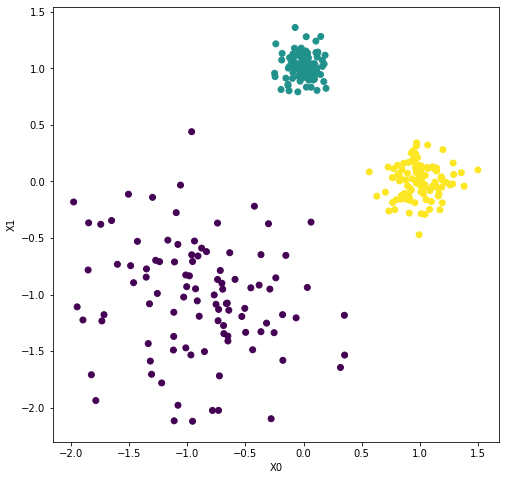

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y)
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.show()

In [52]:
X[:5], y.unique()

(tensor([[-0.4982, -1.3340],
         [-0.9385, -0.5269],
         [-0.7687, -1.0035],
         [-0.6855, -1.3452],
         [-1.0132, -0.8270]]), tensor([0, 1, 2]))

Sanity check if the `HyperModelAndPlot` class works for classification as we would expect

output_fun linear
HyperModel(
  (dense): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
  )
)
number of parameters 36 => [torch.Size([5, 2]), torch.Size([5]), torch.Size([2, 5]), torch.Size([2]), torch.Size([3, 2]), torch.Size([3])]


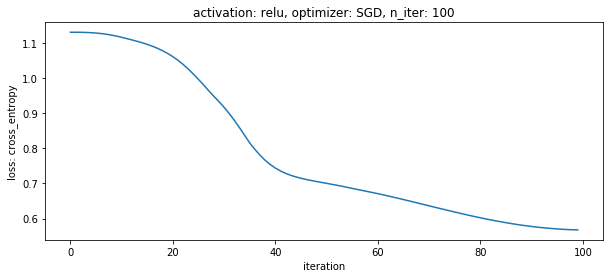

In [53]:
MAP = HyperModelAndPlot(X, y)
device = torch.device("cpu")
MAP.dynamic_fit(activation_fun="relu", optimizer="SGD", scheduler="CyclicLR", loss="cross_entropy", 
                n_iter=100, lr=.001, max_lr=.1, hidden="5,2", output_fun="linear", dim_out=n_c)

Defining the plot function to visualize the three scores (columns) for each class (rows)

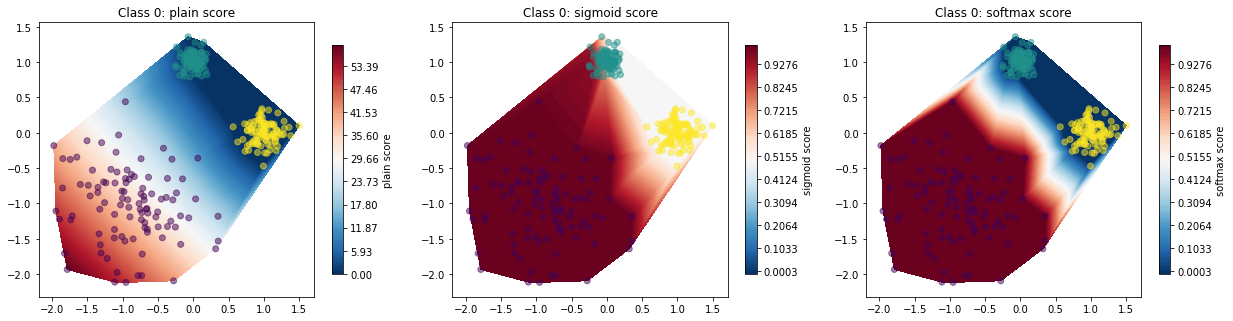

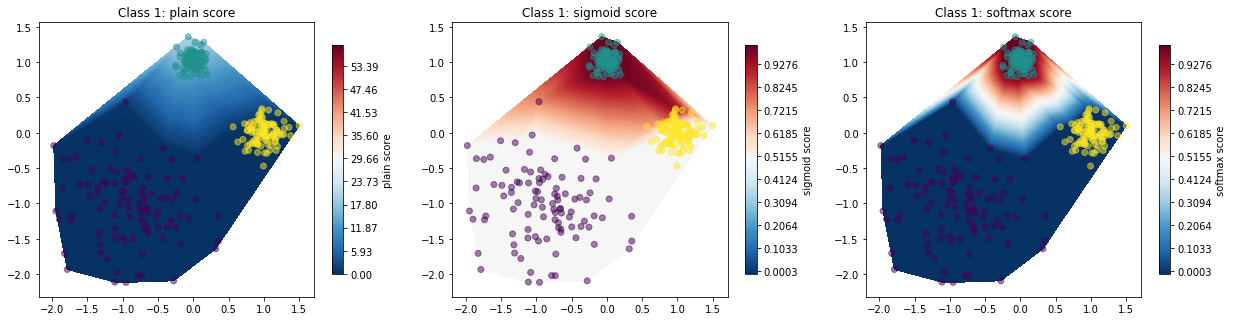

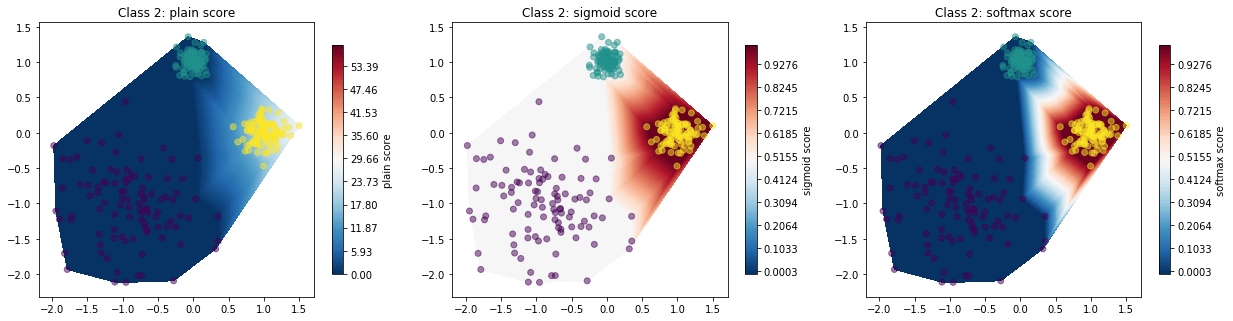

Wall time: 2.69 s


In [123]:
%%time
def plot_class_contours(X, y, y_pred, figsize = (21,7)):
    
    norms = [
        colors.Normalize(vmin=y_pred.min(), vmax=y_pred.max()),  # norm for plain score
        colors.Normalize(vmin=-.01, vmax=1.01),  # norm for sigmoid score
        colors.Normalize(vmin=-.01, vmax=1.01)  # norm for softmax score
    ]
    levels = [np.linspace(n.vmin, n.vmax, 100) for n in norms]
    n_c = y_pred.shape[1]
    
    sigmoid = 1/(1+np.exp(-y_pred))
    softmax = np.exp(y_pred)/np.exp(y_pred).sum(axis=1)[:,None]
    
    for i in range(n_c):
        fig, axs = plt.subplots(figsize=figsize, ncols=3)

        for j,_s in enumerate([y_pred[:,i], sigmoid[:,i], softmax[:,i]]):
            sname = 'plain' if j==0 else 'sigmoid' if j==1 else 'softmax'
            ax = axs[j]
            ax.set_aspect("equal")
            cont = ax.tricontourf(X[:,0], X[:,1], _s, levels=levels[j], cmap="RdBu_r", norm=norms[j])
            cb = fig.colorbar(cont, ax=ax, shrink=.6, extend="both") #, extendfrac="auto"
            cb.ax.set_ylabel(f"{sname} score")
            ax.scatter(X[:,0], X[:,1], c=y, marker="o", alpha=.5)
            ax.set_title(f"Class {i}: {sname} score")

        plt.show()
                         
plot_class_contours(X, y, MAP.y_pred.detach().numpy())

Jamming a new version of the `dynamic_fit` method into the `HyperModelAndPlot` class (really only added `show_contour` in the arguments and two lines at the end)

In [124]:
def dynamic_fit(self, activation_fun:Union[str,callable]="relu", optimizer:str="Adam", scheduler:str="CyclicLR",
                loss:Union[str,callable]="mse_loss", n_iter:int=10, lr:float=.1, max_lr=.1, 
                hidden:str="5,2", output_fun:Union[str,callable]="linear", dim_out:int=1, show_contour:bool=False):

    _hidden = [int(v) for v in hidden.split(",")]
    assert all([v>0] for v in _hidden), "The number of neurons in each layer needs to be at least 1"
    print("output_fun", output_fun)
    self.m = HyperModel(activation_fun=activation_fun, dim_in=self.X.size()[1], hidden=_hidden, dim_out=dim_out,
                        output_fun=output_fun)
    print(self.m)
    print(f"number of parameters {sum([np.prod(v.size()) for v in self.m.parameters()])} => {[v.size() for v in self.m.parameters()]}")
    self.m.to(device)
    self.opt = getattr(torch.optim, optimizer)(self.m.parameters(), lr=lr)
    self.scheduler = getattr(torch.optim.lr_scheduler, scheduler) if scheduler != "None" else None

    if self.scheduler is not None:
        try:
            self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=True)                
        except ValueError:
            self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=False)

    self._loss = getattr(torch.nn.functional, loss) if isinstance(loss, str) else loss

    self.fit(n_iter)            
    self.plot(n_iter, loss, activation_fun, optimizer)
    
    if show_contour:
        plot_class_contours(self.X, self.y, self.y_pred.detach().numpy(), figsize = (21,7))
    
HyperModelAndPlot.dynamic_fit = dynamic_fit

Let's play with it interactively

In [126]:
%%time

MAP = HyperModelAndPlot(X, y)
widgets.interact(MAP.dynamic_fit, 
                 dim_out=widgets.fixed(n_c),
                 activation_fun=["relu", "softplus", "sigmoid", "tanh"], 
                 optimizer=["Adam", "RMSprop"],
                 scheduler=["None", "CyclicLR"], 
                 loss=widgets.fixed("cross_entropy"), 
                 n_iter=widgets.IntText(value=200),                  
                 lr=widgets.FloatText(value=.01), 
                 max_lr=widgets.FloatText(value=.1),
                 hidden=widgets.Combobox(value="100,5"),
                 output_fun=widgets.fixed("linear"),
                 show_contour=widgets.fixed(True)
                );

interactive(children=(Dropdown(description='activation_fun', options=('relu', 'softplus', 'sigmoid', 'tanh'), …

Wall time: 3.65 s


<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

So replacing softmax with a sigmoid to predict if a class is present or not does sometines work indeed.